In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

In [27]:
(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [28]:
# Reshape converting 2D to 1D
y_test = y_test.reshape(-1,)
y_train = y_train.reshape(-1,)

In [29]:
# This code normalazation
x_train = x_train / 255.0
x_test = x_test / 255.0

In [30]:
x_train.shape

(50000, 32, 32, 3)

In [31]:
# base model
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='relu', input_shape=(32,32,3),padding='same'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(16, 5, activation='tanh',padding='valid'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(120, 5, activation='tanh',padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 activation_2 (Activation)   (None, 16, 16, 6)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_3 (Activation)   (None, 6, 6, 16)         

In [24]:
batch_size=64
epochs=10

In [32]:
# base model accuracy
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history_base = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),verbose=1)

Epoch 1/10
782/782 [==============================] - 66s 75ms/step - loss: 1.5996 - accuracy: 0.4157 - val_loss: 1.4442 - val_accuracy: 0.4790
Epoch 2/10
782/782 [==============================] - 60s 77ms/step - loss: 1.3802 - accuracy: 0.5033 - val_loss: 1.3830 - val_accuracy: 0.5044
Epoch 3/10
782/782 [==============================] - 57s 72ms/step - loss: 1.2968 - accuracy: 0.5353 - val_loss: 1.2606 - val_accuracy: 0.5486
Epoch 4/10
782/782 [==============================] - 56s 71ms/step - loss: 1.2397 - accuracy: 0.5586 - val_loss: 1.2277 - val_accuracy: 0.5607
Epoch 5/10
782/782 [==============================] - 58s 74ms/step - loss: 1.1934 - accuracy: 0.5732 - val_loss: 1.2002 - val_accuracy: 0.5648
Epoch 6/10
782/782 [==============================] - 56s 72ms/step - loss: 1.1492 - accuracy: 0.5921 - val_loss: 1.1846 - val_accuracy: 0.5749
Epoch 7/10
782/782 [==============================] - 57s 73ms/step - loss: 1.1162 - accuracy: 0.6045 - val_loss: 1.1487 - val_accuracy:

In [33]:
# Test baseline accuracy
import tempfile

_, baseline_model_accuracy = model.evaluate(x_test,y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)


Baseline test accuracy: 0.599399983882904


In [34]:
# base model saved location
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpuxky2pj5.h5


In [35]:
###############################
########### PRUNING ###########
###############################

In [36]:
pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 8.0 MB/s 


In [37]:
## Prunning the entire dataset

import tensorflow_model_optimization as tfmot
import numpy as np

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# batch_size & epochs stay the same as the baseline model
batch_size = 64
epochs = 5


# Define model for pruning.
# For the pruning schedule, we start at the sparsity level 50% 
# and gradually train the model to reach 90% sparsity. 
# 90% of the weight tensor is going to be pruned away.

x = 0.2
sparsity = []
acc = []
while x <= 0.9:
  print("current x is: ",x)
  sparsity.append(x)
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(x, begin_step=0, frequency=100)
  }
  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

  history_pruned = model_for_pruning.fit(x_train,y_train,
                      batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                      callbacks=callbacks)
    
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_train,y_train, verbose=0)

  print("current x is: ",x, "and model acc is: ",model_for_pruning_accuracy)
  acc.append(model_for_pruning_accuracy)
  print("sparsity: ", sparsity)
  print("accuracy list: ", acc)
  x += 0.1

# model_for_pruning.summary()

current x is:  0.2
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 65s 78ms/step - loss: 0.9846 - accuracy: 0.6549 - val_loss: 1.0687 - val_accuracy: 0.6222
Epoch 2/5
782/782 [==============================] - 64s 82ms/step - loss: 0.9562 - accuracy: 0.6626 - val_loss: 1.0714 - val_accuracy: 0.6198
Epoch 3/5
782/782 [==============================] - 60s 77ms/step - loss: 0.9399 - accuracy: 0.6737 - val_loss: 1.1061 - val_accuracy: 0.6072
Epoch 4/5
782/782 [==============================] - 62s 79ms/step - loss: 0.9175 - accuracy: 0.6805 - val_loss: 1.0684 - val_accuracy: 0.6274
Epoch 5/5
782/782 [==============================] - 60s 76ms/step - loss: 0.9011 - accuracy: 0.6835 - val_loss: 1.0593 - val_accuracy: 0.6297
current x is:  0.2 and model acc is:  0.7028999924659729
sparsity:  [0.2]
accuracy list:  [0.7028999924659729]
current x is:  0.30000000000000004
Epoch 1/5
782/782 [==============================] - 64s 79ms/step - loss: 0.8752 - accuracy: 0.6903 - val_loss: 1.0382 - val_accuracy: 0.6354
Epoch 

In [43]:
sparsity = [round(x, 2) for x in sparsity]
sparsity

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [44]:
acc

[0.7028999924659729,
 0.7268999814987183,
 0.7552800178527832,
 0.7737799882888794,
 0.7806400060653687,
 0.7821400165557861,
 0.7302799820899963,
 0.6231799721717834]

In [45]:
# # fit the pruned model

# logdir = tempfile.mkdtemp()

# callbacks = [
#   tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
# ]

# history_pruned = model_for_pruning.fit(x_train,y_train,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

In [46]:
# Test out pruned model accuracy
# _, model_for_pruning_accuracy = model_for_pruning.evaluate(
#    x_train,y_train, verbose=0)

In [47]:
# compare results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.599399983882904
Pruned test accuracy: 0.6231799721717834


In [48]:
# Once our pre-trained model achieved desirable accuracy
# we save the model trained model and make it “prunable”
# _, keras_file = tempfile.mkstemp('.h5')
# tf.keras.models.save_model(model_for_pruning, keras_file, include_optimizer=False)
# print('Saved baseline model to:', keras_file)

In [49]:
compression_ratio = [1/x for x in sparsity]
compression_ratio

[5.0,
 3.3333333333333335,
 2.5,
 2.0,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111112]

In [50]:
acc

[0.7028999924659729,
 0.7268999814987183,
 0.7552800178527832,
 0.7737799882888794,
 0.7806400060653687,
 0.7821400165557861,
 0.7302799820899963,
 0.6231799721717834]

In [51]:
# pruned model saved
_, pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', pruned_keras_file)
tf.keras.models.save_model(model_for_pruning, pruned_keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpvl_c46r1.h5


In [52]:
###############################
###### PRUNING RESULT #########
###############################

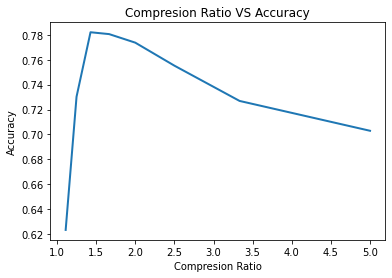

In [53]:
# compression ratio vs accuracy graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.scatter(compression_rat, acc)
ax.plot(compression_ratio, acc, linewidth=2.0)
plt.xlabel('Compresion Ratio')
plt.ylabel('Accuracy')
plt.title('Compresion Ratio VS Accuracy')
plt.show()

In [54]:
# accuracy results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy (90% pruned rate):', model_for_pruning_accuracy)

Baseline test accuracy: 0.599399983882904
Pruned test accuracy (90% pruned rate): 0.6231799721717834


In [55]:
# pruned model summary
# model_for_pruning.summary()

In [56]:
# base model summary
# model.summary()

In [57]:
# helper function to get model size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [58]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))

Size of gzipped baseline Keras model: 346362.00 bytes
Size of gzipped pruned Keras model: 91857.00 bytes


In [59]:
# confusion matrix for based model
from sklearn.metrics import confusion_matrix
import numpy as np
test_predictions = model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

313/313 [==============================] - 6s 18ms/step


array([[717,  25,  45,  11,  32,  10,   8,   3, 106,  43],
       [ 33, 708,   8,   9,  14,   9,  17,   4,  53, 145],
       [ 93,  11, 418,  56, 156, 142,  55,  32,  19,  18],
       [ 51,  12,  64, 338,  99, 265,  65,  42,  29,  35],
       [ 54,   4,  77,  61, 603,  52,  50,  69,  24,   6],
       [ 23,   5,  53, 132,  81, 594,  23,  61,  16,  12],
       [ 18,  17,  39,  61, 113,  61, 624,  17,  18,  32],
       [ 29,   5,  45,  45,  98, 111,  15, 593,   9,  50],
       [116,  56,  10,  13,   6,  13,   8,   8, 740,  30],
       [ 41, 123,  12,  19,  11,  15,  15,  15,  63, 686]])

In [60]:
# confusion matrix for pruned model
p_test_predictions = model_for_pruning.predict(x_test)
p_confusion = confusion_matrix(y_test, np.argmax(p_test_predictions,axis=1))
p_confusion

313/313 [==============================] - 6s 18ms/step


array([[717,  25,  45,  11,  32,  10,   8,   3, 106,  43],
       [ 33, 708,   8,   9,  14,   9,  17,   4,  53, 145],
       [ 93,  11, 418,  56, 156, 142,  55,  32,  19,  18],
       [ 51,  12,  64, 338,  99, 265,  65,  42,  29,  35],
       [ 54,   4,  77,  61, 603,  52,  50,  69,  24,   6],
       [ 23,   5,  53, 132,  81, 594,  23,  61,  16,  12],
       [ 18,  17,  39,  61, 113,  61, 624,  17,  18,  32],
       [ 29,   5,  45,  45,  98, 111,  15, 593,   9,  50],
       [116,  56,  10,  13,   6,  13,   8,   8, 740,  30],
       [ 41, 123,  12,  19,  11,  15,  15,  15,  63, 686]])

In [61]:
###############################
######## Quantization #########
###############################

In [62]:
## Quantization 
import tensorflow_model_optimization as tfmot

model_quant = tfmot.quantization.keras.quantize_model(model)
model_quant.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model_quant.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d_5 (QuantizeWra  (None, 32, 32, 6)        471       
 pperV2)                                                         
                                                                 
 quant_average_pooling2d_2 (  (None, 16, 16, 6)        3         
 QuantizeWrapperV2)                                              
                                                                 
 quant_activation_2 (Quantiz  (None, 16, 16, 6)        3         
 eWrapperV2)                                                     
                                                                 
 quant_conv2d_6 (QuantizeWra  (None, 12, 12, 16)      

In [64]:
model_quant.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 76s 97ms/step - loss: 1.0935 - accuracy: 0.6127 - val_loss: 1.0451 - val_accuracy: 0.6326
Epoch 2/5
782/782 [==============================] - 71s 91ms/step - loss: 0.9672 - accuracy: 0.6597 - val_loss: 1.0834 - val_accuracy: 0.6205
Epoch 3/5
782/782 [==============================] - 69s 88ms/step - loss: 0.8988 - accuracy: 0.6875 - val_loss: 1.0781 - val_accuracy: 0.6323
Epoch 4/5
782/782 [==============================] - 77s 98ms/step - loss: 0.8610 - accuracy: 0.6995 - val_loss: 0.9800 - val_accuracy: 0.6645
Epoch 5/5
782/782 [==============================] - 69s 88ms/step - loss: 0.8201 - accuracy: 0.7126 - val_loss: 1.0231 - val_accuracy: 0.6486


In [65]:
# quant model saved
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
quant_tflite_model = converter.convert()

_, quant_tflite_file = tempfile.mkstemp('.h5')

with open(quant_tflite_file, 'wb') as f:
  f.write(quant_tflite_model)

print('Saved pruned TFLite model to:', quant_tflite_file)


Saved pruned TFLite model to: /tmp/tmp3wvwxkwp.h5


In [66]:
#####################################
######## Quantization Result#########
#####################################

In [67]:
# Accuracy comparisons
_, model_quant_accuracy = model_quant.evaluate(x_train,y_train, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Quantization test accuracy:', model_quant_accuracy)

Baseline test accuracy: 0.599399983882904
Quantization test accuracy: 0.7170000076293945


In [80]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped quantization Keras model: %.2f bytes" % (get_gzipped_model_size(quant_tflite_file)))

Size of gzipped baseline Keras model: 346362.00 bytes
Size of gzipped quantization Keras model: 298284.00 bytes


In [68]:
#########################################
######## Pruning + Quantization #########
#########################################

In [69]:
## Prunning the entire dataset

import tensorflow_model_optimization as tfmot
import numpy as np

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# batch_size & epochs stay the same as the baseline model
batch_size = 64
epochs = 5


# Define model for pruning.
# For the pruning schedule, we start at the sparsity level 50% 
# and gradually train the model to reach 90% sparsity. 
# 90% of the weight tensor is going to be pruned away.

x = 0.2
sparsity_pq = []
acc_pq = []
while x <= 0.9:
  print("current x is: ",x)
  sparsity_pq.append(x)
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(x, begin_step=0, frequency=100)
  }
  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

  history_pruned = model_for_pruning.fit(x_train,y_train,
                      batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),
                      callbacks=callbacks)

                      
  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
  model_quant_prune = tfmot.quantization.keras.quantize_model(model_for_export)
  model_quant_prune.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
  model_quant_prune.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))
    
  _, model_quant_prune_accuracy = model_quant_prune.evaluate(x_train,y_train, verbose=0)

  print("current x is: ",x, "and model acc is: ",model_quant_prune_accuracy)
  acc_pq.append(model_quant_prune_accuracy)
  print("sparsity: ", sparsity_pq)
  print("accuracy list: ", acc_pq)
  x += 0.1

# model_for_pruning.summary()

current x is:  0.2
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 59s 73ms/step - loss: 1.0651 - accuracy: 0.6261 - val_loss: 0.9417 - val_accuracy: 0.6740
Epoch 2/5
782/782 [==============================] - 55s 70ms/step - loss: 0.9451 - accuracy: 0.6667 - val_loss: 0.8515 - val_accuracy: 0.6920
Epoch 3/5
782/782 [==============================] - 56s 72ms/step - loss: 0.8831 - accuracy: 0.6909 - val_loss: 0.7934 - val_accuracy: 0.7245
Epoch 4/5
782/782 [==============================] - 55s 70ms/step - loss: 0.8383 - accuracy: 0.7058 - val_loss: 0.7852 - val_accuracy: 0.7285
Epoch 5/5
782/782 [==============================] - 55s 70ms/step - loss: 0.8014 - accuracy: 0.7212 - val_loss: 0.7428 - val_accuracy: 0.7405
Epoch 1/5
782/782 [==============================] - 63s 79ms/step - loss: 0.8347 - accuracy: 0.7078 - val_loss: 0.7538 - val_accuracy: 0.7220
Epoch 2/5
782/782 [==============================] - 61s 78ms/step - loss: 0.7893 - accuracy: 0.7224 - val_loss: 0.7318 - val_accuracy: 0.7360
Epoch 3/5

In [70]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')
with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

In [71]:
#########################################
##### Pruning + Quantization Result #####
#########################################

In [72]:
compression_pq_ratio = [1/x for x in sparsity_pq]
compression_pq_ratio

[5.0,
 3.333333333333333,
 2.5,
 2.0,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111112]

In [73]:
acc_pq

[0.7804800271987915,
 0.7808200120925903,
 0.8275600075721741,
 0.8320000171661377,
 0.8523600101470947,
 0.8290200233459473,
 0.8263999819755554,
 0.7818199992179871]

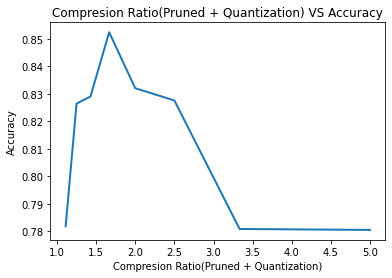

In [74]:
# compression ratio vs accuracy graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.scatter(compression_rat, acc)
ax.plot(compression_pq_ratio, acc_pq, linewidth=2.0)
plt.xlabel('Compresion Ratio(Pruned + Quantization)')
plt.ylabel('Accuracy')
plt.title('Compresion Ratio(Pruned + Quantization) VS Accuracy')
plt.show()

In [75]:
# accuracy results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned + Quantization test accuracy:', model_quant_prune_accuracy)

Baseline test accuracy: 0.599399983882904
Pruned + Quantization test accuracy: 0.7818199992179871


In [76]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Size of gzipped baseline Keras model: 346362.00 bytes
Size of gzipped pruned and quantized TFlite model: 24468.00 bytes


In [77]:
# confusion matrix for based model
from sklearn.metrics import confusion_matrix
import numpy as np
test_predictions = model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

313/313 [==============================] - 6s 19ms/step


array([[694,  34,  55,  22,  16,   3,  12,  16, 101,  47],
       [ 20, 785,   4,   8,   6,   3,  17,   7,  44, 106],
       [ 78,  15, 465,  84, 123,  72,  65,  55,  26,  17],
       [ 22,  19,  81, 407,  88, 161,  85,  61,  40,  36],
       [ 36,   7,  82,  80, 579,  28,  73,  88,  16,  11],
       [ 16,   9,  70, 187,  64, 497,  39,  94,  10,  14],
       [ 14,   8,  34,  67,  62,  40, 724,  17,  15,  19],
       [ 17,   7,  40,  62,  78,  63,  12, 677,  10,  34],
       [ 83,  60,  13,  22,   6,   4,   5,   4, 772,  31],
       [ 35, 136,  11,  21,   7,  12,  11,  22,  53, 692]])

In [78]:
# confusion matrix for pruned+quantized model
pq_test_predictions = model_quant_prune.predict(x_test)
pq_confusion = confusion_matrix(y_test, np.argmax(pq_test_predictions,axis=1))
pq_confusion

313/313 [==============================] - 7s 21ms/step


array([[737,  59,  45,  22,  23,   3,   6,  16,  55,  34],
       [  9, 861,   6,   9,   4,   1,  13,   7,  17,  73],
       [ 62,  16, 589,  70,  81,  37,  48,  64,  13,  20],
       [ 27,  22,  87, 489,  85,  96,  56,  69,  25,  44],
       [ 28,  11,  90,  78, 591,  24,  43, 115,  15,   5],
       [ 16,  10,  77, 250,  49, 438,  30, 100,  13,  17],
       [  8,  17,  53,  79,  54,  20, 721,  20,   8,  20],
       [ 14,  12,  46,  39,  54,  32,   7, 764,   5,  27],
       [ 82,  70,  16,  12,   3,   0,   4,  10, 775,  28],
       [ 29, 163,  12,  18,  13,   4,   6,  17,  25, 713]])